## Q5: Implement Kernel PCA for Logistic Regression

Datasets: 

1. Twospirals: 1000 2-dim datapoints

2. Threecircles: 1000 2-dim datapoints



In [2]:
import torchvision
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as transforms
import pandas as pd
import numpy as np

In [3]:
# data loading

two_spirals = pd.read_csv('twospirals.txt', sep='\t', names=['x', 'y', 'label'])

three_circles = pd.read_csv('threecircles.txt', sep=',', names=['x', 'y', 'label'])

print(two_spirals.head())
print(three_circles.head())

         x        y  label
0  10.5192  -0.7170   -1.0
1   0.9987  -9.9681   -1.0
2   3.5763   8.3756   -1.0
3   1.9236 -10.6448   -1.0
4   8.1583  -5.9066   -1.0
          x         y  label
0 -0.208626 -0.264189     -1
1  0.499955 -0.073624     -1
2 -0.241661 -0.221071     -1
3 -0.356841  0.204201     -1
4  0.529480  0.170605     -1


In [4]:
#A) Train a linear/logistic regression model (library, logistic if data labels are categiories) and confirm that it doesnt work: high classification error or high Root MSE.

class LogisticRegressionModel(nn.Module):
    def __init__(self, input_dim):
        super(LogisticRegressionModel, self).__init__()
        self.linear = nn.Linear(input_dim, 1)

    def forward(self, x):
        return torch.sigmoid(self.linear(x))

log_reg_model = LogisticRegressionModel(2)


In [5]:
# train / test
X = two_spirals[['x', 'y']].values
y = two_spirals['label'].values

# Convert labels from -1 and 1 to 0 and 1
y = (y + 1) / 2

X = torch.tensor(X, dtype=torch.float32)
y = torch.tensor(y, dtype=torch.float32).view(-1, 1)

criterion = nn.MSELoss()
optimizer = optim.SGD(log_reg_model.parameters(), lr=0.01)

for epoch in range(1000):
    optimizer.zero_grad()
    outputs = log_reg_model(X)
    loss = criterion(outputs, y)
    loss.backward()
    optimizer.step()

    if epoch % 100 == 0:
        print(f'epoch {epoch}, loss {loss.item()}')

# test
outputs = log_reg_model(X)
print(outputs)
print(y)



epoch 0, loss 0.3057234287261963
epoch 100, loss 0.2393454909324646
epoch 200, loss 0.2222510129213333
epoch 300, loss 0.22025173902511597
epoch 400, loss 0.21910856664180756
epoch 500, loss 0.21808914840221405
epoch 600, loss 0.217182457447052
epoch 700, loss 0.2163822203874588
epoch 800, loss 0.21568068861961365
epoch 900, loss 0.2150695025920868
tensor([[0.2584],
        [0.3661],
        [0.6171],
        [0.3287],
        [0.2420],
        [0.6171],
        [0.3022],
        [0.2303],
        [0.7405],
        [0.6091],
        [0.4464],
        [0.3124],
        [0.4711],
        [0.2837],
        [0.6815],
        [0.4926],
        [0.5509],
        [0.2349],
        [0.2540],
        [0.2362],
        [0.6174],
        [0.7931],
        [0.4237],
        [0.3025],
        [0.3924],
        [0.2807],
        [0.4766],
        [0.4287],
        [0.6326],
        [0.5901],
        [0.3169],
        [0.3145],
        [0.2466],
        [0.4333],
        [0.4322],
        [0.2999],
 

C:\Users\koola\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\torch\functional.py:534: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\TensorShape.cpp:3596.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


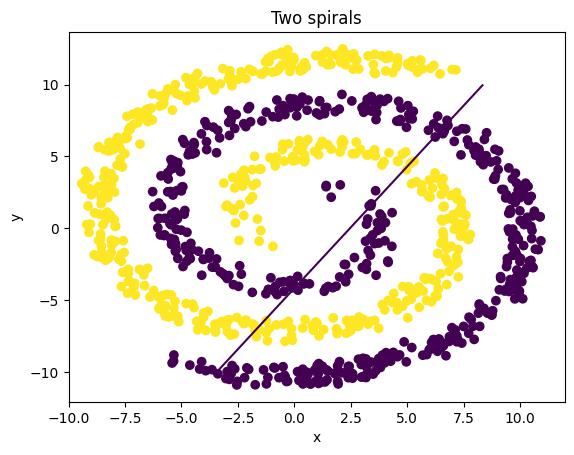

In [6]:
# visualize: plot the data points and the decision boundary
import matplotlib.pyplot as plt

plt.scatter(two_spirals['x'], two_spirals['y'], c=two_spirals['label'])
plt.xlabel('x')
plt.ylabel('y')
plt.title('Two spirals')
# plot decision boundary
x = torch.linspace(-10, 10, 100)
y = torch.linspace(-10, 10, 100)
X, Y = torch.meshgrid(x, y)
Z = torch.zeros(X.shape)
for i in range(X.shape[0]):
    for j in range(X.shape[1]):
        Z[i, j] = log_reg_model(torch.tensor([X[i, j], Y[i, j]], dtype=torch.float32)).detach()
plt.contour(X.numpy(), Y.numpy(), Z.numpy(), levels=[0.5])

plt.show()


In [7]:
# Run kernelPCA with a Gaussian Kernel to obtain a representation of T features. 
# Use the kernelPCA representation as input to a linear regression model (dualizaed form of data).

from sklearn.decomposition import KernelPCA
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

X = two_spirals[['x', 'y']].values
y = two_spirals['label'].values

# Convert labels from -1 and 1 to 0 and 1
y = (y + 1) / 2


In [8]:
# steps demo'd in class:

#get pairwise squared euclidean distance:
x2 = np.sum(X**2, axis=1)
dist = x2[:, None] + x2[None, :] - 2 * np.dot(X, X.T)

# kernel matrix
sigma = 3
# K = np.exp(-dist / (2 * sigma**2))
K = np.exp(-dist / sigma)

# normalize kernel to correspond to zero-mean
U = np.ones(K.shape) / K.shape[0]
K = K - U @ K - K @ U + U @ K @ U

# eigenvalues and eigenvectors, sort them with largest eig first
eigvals, eigvecs = np.linalg.eigh(K)
idx = np.argsort(eigvals)[::-1]
eigvals = eigvals[idx]
eigvecs = eigvecs[:, idx]
 

# project data to the first:
# 3 eigenvectors
X_3_kpca = eigvecs[:, :3] * np.sqrt(eigvals[:3])
# 20 eigenvectors
X_20_kpca = eigvecs[:, :20] * np.sqrt(eigvals[:20])
# 100 eigenvectors
X_100_kpca = eigvecs[:, :100] * np.sqrt(eigvals[:100])

In [9]:
# Retrain the linear regression model with the kernelPCA representation (dualized data)

X_train, X_test, y_train, y_test = train_test_split(X_3_kpca, y, test_size=0.2)

lin_reg_model = LinearRegression()
lin_reg_model.fit(X_train, y_train)
y_pred = lin_reg_model.predict(X_test)
print(mean_squared_error(y_test, y_pred))


0.20742980090412208


In [10]:
X_train, X_test, y_train, y_test = train_test_split(X_20_kpca, y, test_size=0.2)

lin_reg_model = LinearRegression()
lin_reg_model.fit(X_train, y_train)
y_pred = lin_reg_model.predict(X_test)
print(mean_squared_error(y_test, y_pred))

0.04728575494292965


In [11]:
X_train, X_test, y_train, y_test = train_test_split(X_100_kpca, y, test_size=0.2)

lin_reg_model = LinearRegression()
lin_reg_model.fit(X_train, y_train)
y_pred = lin_reg_model.predict(X_test)
print(mean_squared_error(y_test, y_pred))

0.0027278212582982153


In [12]:
# run on three circles

X = three_circles[['x', 'y']].values
y = three_circles['label'].values

# steps demo'd in class:

#get pairwise squared euclidean distance:
x2 = np.sum(X**2, axis=1)
dist = x2[:, None] + x2[None, :] - 2 * np.dot(X, X.T)

# kernel matrix
sigma = 3
# K = np.exp(-dist / (2 * sigma**2))
K = np.exp(-dist / sigma)

# normalize kernel to correspond to zero-mean
U = np.ones(K.shape) / K.shape[0]
K = K - U @ K - K @ U + U @ K @ U

# eigenvalues and eigenvectors, sort them with largest eig first
eigvals, eigvecs = np.linalg.eigh(K)
idx = np.argsort(eigvals)[::-1]
eigvals = eigvals[idx]
eigvecs = eigvecs[:, idx]
 

# project data to the first:
# 3 eigenvectors
X_3_kpca = eigvecs[:, :3] * np.sqrt(eigvals[:3])
# 20 eigenvectors
X_20_kpca = eigvecs[:, :20] * np.sqrt(eigvals[:20])
# 100 eigenvectors
X_100_kpca = eigvecs[:, :100] * np.sqrt(eigvals[:100])

In [ ]:
# Retrain the linear regression model with the kernelPCA representation (dualized data) How large T needs to be to get a good result? -> following shows 3, 20, 100

X_train, X_test, y_train, y_test = train_test_split(X_3_kpca, y, test_size=0.2)

lin_reg_model = LinearRegression()
lin_reg_model.fit(X_train, y_train)
y_pred = lin_reg_model.predict(X_test)
print(mean_squared_error(y_test, y_pred))


0.03110531114031359


In [14]:
# Retrain the linear regression model with the kernelPCA representation (dualized data)

X_train, X_test, y_train, y_test = train_test_split(X_20_kpca, y, test_size=0.2)

lin_reg_model = LinearRegression()
lin_reg_model.fit(X_train, y_train)
y_pred = lin_reg_model.predict(X_test)
print(mean_squared_error(y_test, y_pred))


0.005207759959883422


In [15]:
# Retrain the linear regression model with the kernelPCA representation (dualized data)

X_train, X_test, y_train, y_test = train_test_split(X_100_kpca, y, test_size=0.2)

lin_reg_model = LinearRegression()
lin_reg_model.fit(X_train, y_train)
y_pred = lin_reg_model.predict(X_test)
print(mean_squared_error(y_test, y_pred))


0.0006389254995584576
